# **Sentiment Analysis (Text Classification)**
*   **Downloading Datset from Kaggle to Google Colab**
*   **Text Cleaning**
*   **BERT Model (Feature Engineering)**
*   **DL Model**

In [1]:
#!/bin/bash
!pip install --quiet kaggle

import os
import json

# Set up Kaggle API credentials
#os.environ['KAGGLE_CONFIG_DIR'] = "/content"
#/content/kaggle.json
# Make the Kaggle API key available to the environment
with open('/content/kaggle.json') as f:
    kaggle_json = json.load(f)
    os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
    os.environ['KAGGLE_KEY'] = kaggle_json['key']

#!/bin/bash
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 19% 5.00M/25.7M [00:00<00:00, 37.4MB/s]
100% 25.7M/25.7M [00:00<00:00, 120MB/s] 
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [1]:
!pip install -U "tensorflow-text==2.13.*"

# **Importing Preprocessing Libraries**

In [2]:
#!pip install --quiet tensorflow_text

import re
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import stopwords

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')


stopwords.words('english')
exclude = string.punctuation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **Reading Data**

In [3]:
temp_df = pd.read_csv('/content/IMDB Dataset.csv')
df = temp_df.iloc[:2000]

# **Text Cleaning & Preprocessing**

In [4]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

#exclude = "!.,?"
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))


In [5]:
df['review'] = df['review'].str.lower()

df['review'] = df['review'].apply(remove_html_tags)

df['review'] = df['review'].apply(remove_url)

df['review'] = df['review'].apply(remove_punc)

#df['review'] = df['review'].apply(word_tokenize)

#df['review'] = df['review'].apply(remove_stopwords)

#df['review'] = df['review'].apply(lemmatize_words)

<ipython-input-5-6f636dc7a57c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].str.lower()
<ipython-input-5-6f636dc7a57c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(remove_html_tags)
<ipython-input-5-6f636dc7a57c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

# **Feature Engineering**

**Target Column Encoding**

In [6]:

from sklearn.preprocessing import LabelEncoder

X = df['review']
Y = df['sentiment']
#print(X)
#print(Y)

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

#print(Y)

X_train,X_test,y_train,y_test = train_test_split(df['review'],Y,test_size=0.2,random_state=42)
print(X_train)
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

968     this is a great film touching and strong the d...
240     this movie was absolutely pathetic a pitiful s...
819     i love jamie foxxand i enjoy 99 of all movies ...
692     picture the scene where a bunch of scriptwrite...
420     this movie starts with the main character lyin...
                              ...                        
1130    i havent had a chance to view the previous fil...
1294    this movie was a masterpiece of human emotions...
860     this production was quite a surprise for me i ...
1459    absolutely wonderful drama and ros is top notc...
1126    amicus made close to a good half dozen of thes...
Name: review, Length: 1600, dtype: object
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


**Finetuning using Deep Learning**

In [7]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4",trainable=True)


text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
#print (text_input)
encoder_inputs = preprocessor(text_input)
#print(encoder_inputs)
outputs = encoder(encoder_inputs)
#print(outputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
#print(pooled_output)

drop_out = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
output = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(drop_out)

model=tf.keras.Model(inputs=[text_input],outputs=[output])

In [8]:
# Compile the mode
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
45/45 [==============================] - 1326s 29s/step - loss: 0.8751 - accuracy: 0.4847 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 2/5
45/45 [==============================] - 1254s 28s/step - loss: 0.7579 - accuracy: 0.5083 - val_loss: 0.6926 - val_accuracy: 0.5312
Epoch 3/5
45/45 [==============================] - 1281s 29s/step - loss: 0.7605 - accuracy: 0.4931 - val_loss: 0.7602 - val_accuracy: 0.4688
Epoch 4/5
45/45 [==============================] - 1312s 29s/step - loss: 0.7502 - accuracy: 0.4931 - val_loss: 0.7525 - val_accuracy: 0.5312
Epoch 5/5
45/45 [==============================] - 1239s 28s/step - loss: 0.7762 - accuracy: 0.5236 - val_loss: 0.7082 - val_accuracy: 0.4688


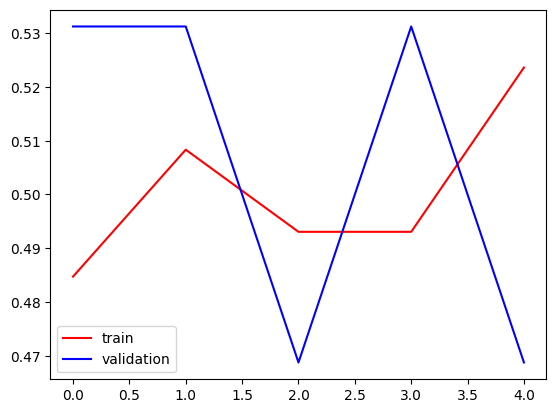

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()